<a href="https://colab.research.google.com/github/vkthakur90/Monte_Carlo_Option_Pricing/blob/main/ARIMA_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
import yfinance as yf

from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [2]:
ticker_list = ["NIFTYBEES.NS","GOLDBEES.NS"]

ar_hist = 200
ar_h = 100  # Prediction Horizon

num_paths = 100000
paths_to_plot = 5

In [3]:
def download_data(entity, ticker_list):
    data_dict = {}

    for ticker in ticker_list:
        print(f"Downloading {ticker}")

        data = yf.download(ticker, period="5y", interval="1d")

        if data.index.tzinfo is None:
            data.index = data.index.tz_localize('UTC')

        data.index = data.index.tz_convert('Asia/Kolkata')

        data_dict[ticker] = pd.Series(data['Close'].values.reshape((-1,)), index = data.index)

    data_ = pd.DataFrame(data_dict)

    entity['data'] = data_

In [4]:
def compute_daily_log_return(entity):
    log_S = entity['data'].apply(np.log)
    prev_log_S = log_S.shift(1)
    entity['daily_log_return'] = 100 * (log_S - prev_log_S)

In [5]:
def split_data(entity):
    entity['train'] = entity['data'].iloc[:-ar_h]
    entity['test'] = entity['data'].iloc[-ar_h:]

    entity['daily_log_return_train'] = entity['daily_log_return'].iloc[:-ar_h].dropna()
    entity['daily_log_return_test'] = entity['daily_log_return'].iloc[-ar_h:].dropna()

In [6]:
def fit_arima(entity):
    params = {}

    for ticker in ticker_list:
        arima_model_fit = ARIMA(entity['daily_log_return_train'][ticker], order=(1, 0, 1)).fit()
        params[ticker] = arima_model_fit.params

    entity['arima_params'] = pd.DataFrame(params)

In [7]:
entity = {}
download_data(entity, ticker_list)
compute_daily_log_return(entity)
split_data(entity)
fit_arima(entity)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

In [8]:
entity['arima_params']

,NIFTYBEES.NS,GOLDBEES.NS
const,0.072626,0.050232
ar.L1,0.031862,0.163987
ma.L1,0.044342,-0.173137
sigma2,0.694270,0.600470


In [9]:
entity['daily_log_return_train'].iloc[-1]["NIFTYBEES.NS"]

np.float64(-0.08091850857132599)

In [10]:
alpha = entity['arima_params'].loc["const", "NIFTYBEES.NS"]
beta = entity['arima_params'].loc["ar.L1", "NIFTYBEES.NS"]
theta = entity['arima_params'].loc["ma.L1", "NIFTYBEES.NS"]
sigma_sq = entity['arima_params'].loc["sigma2", "NIFTYBEES.NS"]

sigma = np.sqrt(sigma_sq)

prev_x = entity['daily_log_return_train'].iloc[-1]["NIFTYBEES.NS"]
display(alpha, beta, theta, sigma)

np.float64(0.0726259326665146)

np.float64(0.031861983054905695)

np.float64(0.044342301401459484)

np.float64(0.8332287777618436)

In [11]:
rand_norm_df = pd.DataFrame(np.random.normal(size=(ar_h, num_paths)), columns = [f'z_{idx + 1}' for idx in range(num_paths)])
prev_rand_norm_df = rand_norm_df.shift(1).fillna(0)

In [12]:
e_df = alpha + theta * sigma * prev_rand_norm_df + sigma * rand_norm_df

In [13]:
x_list = []
prev_x = entity['daily_log_return_train'].iloc[-1]["NIFTYBEES.NS"]

for idx, e in e_df.iterrows():
    x = beta * prev_x + e
    x_list.append(x)
    prev_x = x

x_df = pd.DataFrame(x_list, index = e_df.index)
x_df.columns = [f'x_{idx + 1}' for idx in range(num_paths)]

<Axes: xlabel='None', ylabel='x_1'>

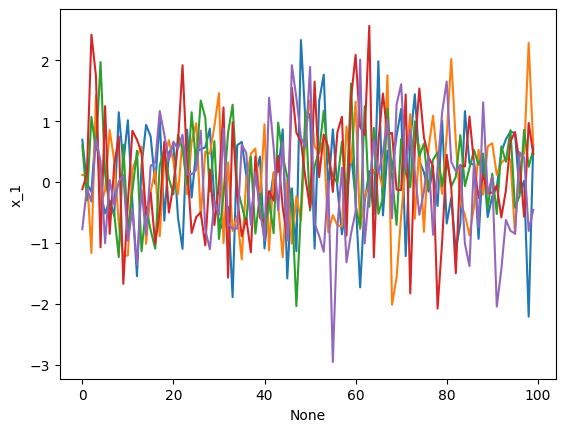

In [14]:
sns.lineplot(data = x_df, x = rand_norm_df.index, y = "x_1")
sns.lineplot(data = x_df, x = rand_norm_df.index, y = "x_2")
sns.lineplot(data = x_df, x = rand_norm_df.index, y = "x_3")
sns.lineplot(data = x_df, x = rand_norm_df.index, y = "x_4")
sns.lineplot(data = x_df, x = rand_norm_df.index, y = "x_5")


In [15]:
S0 = entity['train'].iloc[-1]['NIFTYBEES.NS']

In [16]:
price_df = S0 * (x_df.cumsum() / 100).apply(np.exp)

In [17]:
price_df.index = entity['data'].index[-ar_h:]

<Axes: xlabel='Date', ylabel='NIFTYBEES.NS'>

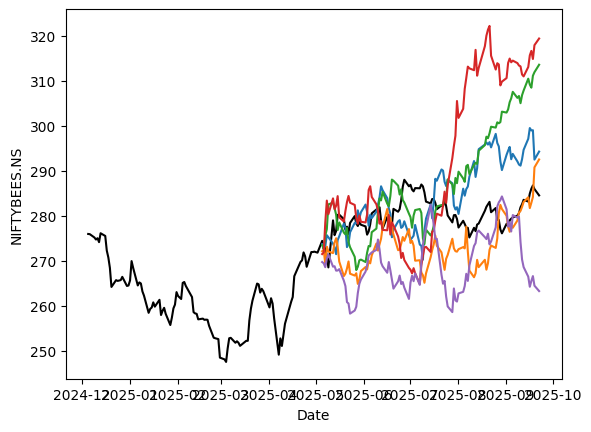

In [18]:
sns.lineplot(data = entity['data'].iloc[-ar_hist:], x = entity['data'].iloc[-ar_hist:].index, y = "NIFTYBEES.NS", color = "black")
sns.lineplot(data = price_df, x = price_df.index, y = "x_1")
sns.lineplot(data = price_df, x = price_df.index, y = "x_2")
sns.lineplot(data = price_df, x = price_df.index, y = "x_3")
sns.lineplot(data = price_df, x = price_df.index, y = "x_4")
sns.lineplot(data = price_df, x = price_df.index, y = "x_5")

In [19]:
quantiles_df = price_df.quantile([0.025, 0.25, 0.5, 0.75, 0.975], axis = 1).T
quantiles_df.columns = ['low_ci', 'first_quart', 'median', 'third_quart', 'high_ci']

<Axes: xlabel='Date', ylabel='NIFTYBEES.NS'>

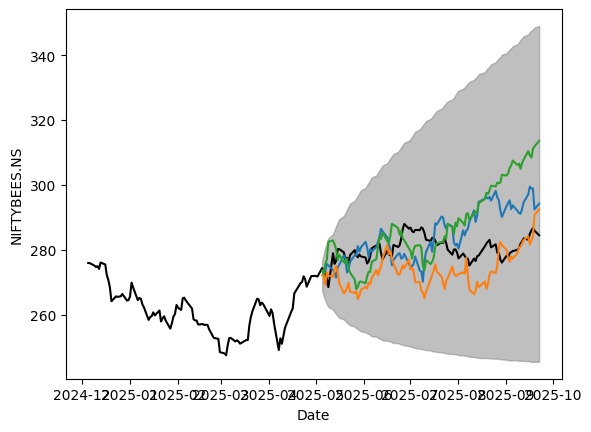

In [20]:
sns.lineplot(data = entity['data'].iloc[-ar_hist:], x = entity['data'].iloc[-ar_hist:].index, y = "NIFTYBEES.NS", color = "black")
plt.fill_between(quantiles_df.index, quantiles_df['low_ci'], quantiles_df['high_ci'], alpha = 0.5, color = 'grey')
sns.lineplot(data = price_df, x = price_df.index, y = "x_1")
sns.lineplot(data = price_df, x = price_df.index, y = "x_2")
sns.lineplot(data = price_df, x = price_df.index, y = "x_3")